# How do we detect seasonality in time series?

The autocorrelation plot (ACF) and periodogram can help us identify seasonality. The ACF displays the correlation for time series observations with its lags (previous observations). If seasonality is present, we will see repeated spikes at multiples of the seasonality window. The periodogram graphs a measure of the relative importance of possible frequency values that might explain the oscillation pattern of the observed data.

We will experiment with several time series in this notebook, obtaining their ACFs and periodograms.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# Daily Minimum Temperatures (Celsius) in Melbourne

Load the data

In [2]:
temp_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', header=0)

How does the data look like? Look at the first 5 rows

In [3]:
temp_data.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


The type of the Date is a string. Let's convert it to datetime.

In [4]:
type(list(temp_data["Date"].values)[0])

str

https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [5]:
temp_data["Date"] = pd.to_datetime(temp_data["Date"], format="%Y-%m-%d")

In [6]:
type(list(temp_data["Date"].values)[0])

numpy.datetime64

Sometimes the csv you get may not have the dates in order. If you convert to datetime, you can easily have Pandas sort it for you.

In [7]:
temp_data = temp_data.sort_values(by=["Date"])

Plot the data

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

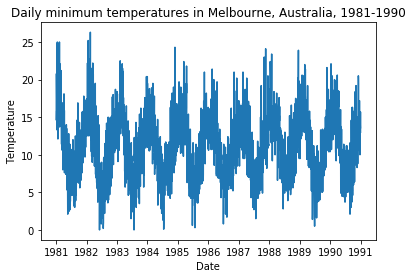

In [9]:
plt.plot(temp_data["Date"], temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"])
plt.title("Daily minimum temperatures in Melbourne, Australia, 1981-1990")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

How does the ACF look like?

$$r_{k} = \frac{\sum\limits_{t=k+1}^T (y_{t}-\bar{y})(y_{t-k}-\bar{y})}
 {\sum\limits_{t=1}^T (y_{t}-\bar{y})^2}$$
where $r_k=$ correlation between $y_t$ and $y_{t-k}$ and $T$ = length of time series

In [10]:
s = pd.Series(temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"].values)

In [11]:
r_k = []
for k in range(1,1000):
    r_k.append(s.autocorr(lag=k))

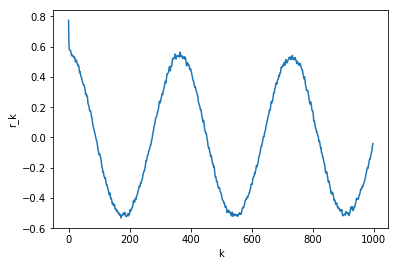

In [12]:
plt.plot(r_k)
plt.xlabel("k")
plt.ylabel("r_k")
plt.show()

There are functions that already plot the ACF for you.

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

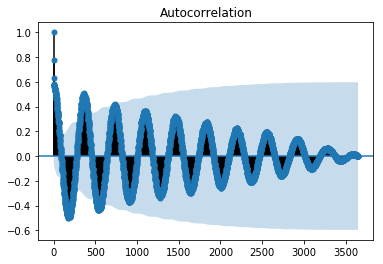

In [14]:
plot_acf(temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"])
plt.show()

The x-axis shows the lag value. The y-axis shows the correlation. This correlation coefficient is between -1 and 1 and describes a negative or positive correlation, respectively. A value of zero indicates no correlation.

API: https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

Let's look at the first 500 lags instead of all the lags.

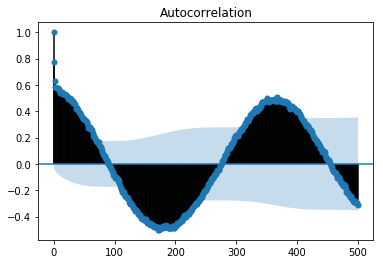

In [15]:
plot_acf(temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"], lags=500)
plt.show()

Let's look at a 99% confidence interval.

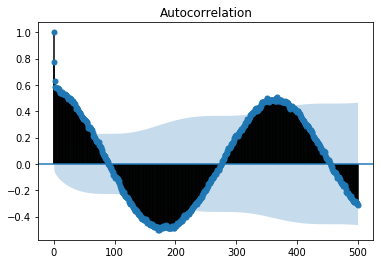

In [16]:
plot_acf(temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"], lags=500, alpha=.01)
plt.show()

What is the periodicity of this data? Recall that a period = \# of time steps required to complete a single cycle

In [17]:
from scipy import signal

A periodogram has:

x-axis is frequency $\frac{j}{n}$

y-axis is

$$P\left(\frac{j}{n}\right) = \widehat{\beta}_1^2\left(\frac{j}{n}\right)+\widehat{\beta}_2^2\left(\frac{j}{n}\right)$$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html

In [18]:
f, P = signal.periodogram(temp_data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"].values)

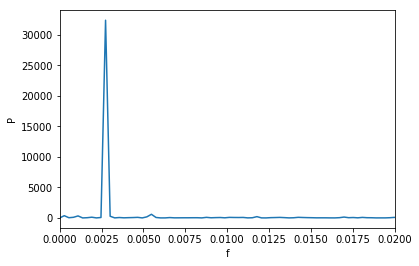

In [19]:
plt.plot(f,P)
plt.xlim([0,.02])
plt.xlabel("f")
plt.ylabel("P")
plt.show()

Large $P(\frac{j}{n})$ $\rightarrow$ Frequency $\frac{j}{n}$ is important in explaining the oscillation in the observed series.

In [20]:
P = list(P)
max_index = P.index(max(P))

In [21]:
f[max_index]

0.0027397260273972603

Frequency = $\frac{1}{\text{period}}$ and since we have the frequency and want the periodicity...

In [22]:
1/f[max_index]

365.0

# Airline Passengers

In [23]:
airline_data = pd.read_csv('data/international-airline-passengers.csv', header=0)
airline_data.head()

,Month,International airline passengers: monthly totals in thousands
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


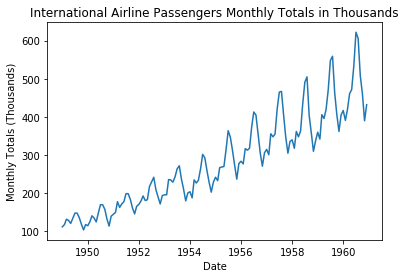

In [24]:
airline_data["Month"] = pd.to_datetime(airline_data["Month"], format="%Y-%m")

plt.plot(airline_data["Month"], airline_data["International airline passengers: monthly totals in thousands"])
plt.title("International Airline Passengers Monthly Totals in Thousands")
plt.xlabel("Date")
plt.ylabel("Monthly Totals (Thousands)")
plt.show()

What kind of seasonality does this look like? Additive or multiplicative?

The ACF appears to have two kinds of patterns...

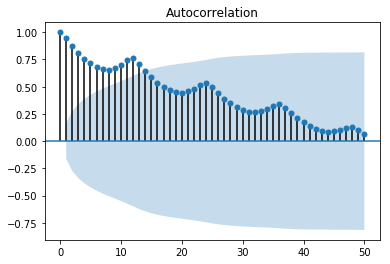

In [25]:
plot_acf(airline_data["International airline passengers: monthly totals in thousands"], lags=50)
plt.show()

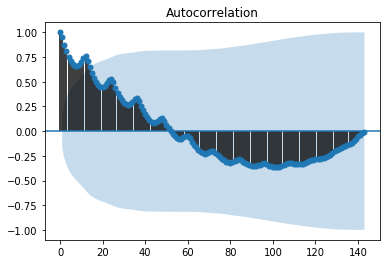

In [26]:
plot_acf(airline_data["International airline passengers: monthly totals in thousands"], lags=143)
plt.show()

What is the periodicity of this dataset?

In [27]:
f, P = signal.periodogram(airline_data["International airline passengers: monthly totals in thousands"].values)

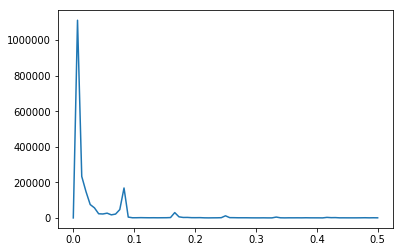

In [28]:
plt.plot(f,P)
plt.show()

In [29]:
P = list(P)
print(max(P))
max_index = P.index(max(P))
1/f[max_index]

1111915.053041475


144.0

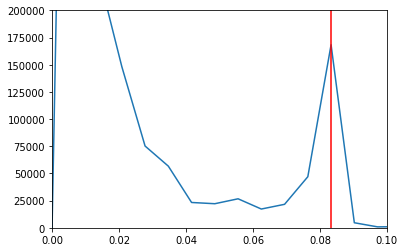

In [30]:
plt.plot(f,P)
plt.xlim([0,.1])
plt.ylim([0,200000])
plt.axvline(x=.0834,color='red')

plt.show()

In [31]:
1/.0834

11.990407673860911

R function to automatically determine it: findfrequency

https://www.rdocumentation.org/packages/forecast/versions/8.12



In [32]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

In [33]:
forecast = importr("forecast")
findfrequency = robjects.r('findfrequency')

In [34]:
converted_vals = robjects.FloatVector(list(airline_data["International airline passengers: monthly totals in thousands"].values))
result = findfrequency(converted_vals)
freq = result[0]
freq

12